## Implementation of the 10-armed Testbed from Chapter 2.3 in the book.

### 1. Creating the Testbed, with 2000 10-armed bandit problems

In [83]:
K_ARMS = 10
NUM_BANDIT_PROBLEMS = 2000
NUM_TIME_STEPS = 1000
STD = 1 # Since STD is 1 for all distributions, we can just sample with the box-muller-method

In [111]:
import numpy as np
from matplotlib import pyplot as plt

# Sample from Normal Gaussian Distribution with Mean 0 and Variance 1 with the Box-Muller Method
seed_1 = 0 
seed_2 = 2**20
m = 2**32
def rand_int(use_seed_1 = True):
    global seed_1
    global seed_2
    # Create random numbers after NUMERICAL RECIPES
    global m
    a, b = 1664525, 1013904223
    random_int = 0
    if use_seed_1:
        random_int = (a * seed_1 + b) % m
        seed_1 = random_int # overwrite global seed_1
    else:
        random_int = (a * seed_2 + b) % m
        seed_2 = random_int # overwrite global seed_2
    return random_int

def rand_float(use_seed_1 = True):
    global m
    random_int = rand_int(use_seed_1)
    return random_int / m # divide by m to get a floating value between 0 and 1

def box_muller_method():
    # Create independent random numbers between 0 and 1
    u1 = rand_float(use_seed_1 = True)
    u2 = rand_float(use_seed_1 = False)
    # Create random numbers following the normal distribution with mean = 0 and variance = 1
    z1 = np.cos(2* np.pi * u1) * np.sqrt(-2 * np.log(u2))
    z2 = np.sin(2* np.pi * u1) * np.sqrt(-2 * np.log(u2))
    return z1, z2

def create_bandit_problem(k_arms = K_ARMS):
    means_of_distributions_behind_arms = []
    for _ in range(k_arms):
        # The distributions behind the arms: Variance should always be 1, mean should be sampled by normal distribution
        mean, _ = box_muller_method()
        means_of_distributions_behind_arms.append(mean)
    return means_of_distributions_behind_arms

def create_test_bed(num_bandit_problems = NUM_BANDIT_PROBLEMS):
    test_bed = []
    for _ in range(num_bandit_problems):
        test_bed.append(create_bandit_problem(k_arms = K_ARMS))
    return test_bed

test_bed = create_test_bed()
print("len(test_bed) (should be 2000):", len(test_bed))
print("len(test_bed[23]) (should be 23):", len(test_bed[23]))
#plt.hist(test_bed[10]) # saved mean values for the normal distributions after each bandit arm, mean values should also follow the normal distribution
print()

def sample_from_bandit_arm(mean_of_dist):
    # Sampling from a bandit arm is like sampling from a normal distributions and adding the mean of the distribution
    # We can do it like this, because the Variances are 1 for all of the distributions 
    _, z2 = box_muller_method()
    return z2 + mean_of_dist

def sample_from_bandit_problem(bandit_problem, arm_index):
    mean_of_dist = bandit_problem[arm_index] # We can do it like this, because we only have to save the means for each bandit problem, because all STDs are 1
    return sample_from_bandit_arm(mean_of_dist)


def sample_random_from_list(array):
    random_int = rand_int()
    random_index_this_array = random_int % len(array)
    random_value_this_array = array[random_index_this_array]
    return random_value_this_array 

def max_index_and_value(list):
    max_index = 0
    max_val = list[0]
    for index, val in enumerate(list):
        if val > max_val:
            max_val = val
            max_index = index
    return max_index, max_val

def choose_greedy_action_index(array):
    _, max_value = max_index_and_value(array)
    max_positions = [] 
    for index, val in enumerate(array):
        if val == max_value:
            max_positions.append(index)

    if len(max_positions) == 1: # One max value, choose this as greedy action
        return max_positions[0]
    else: # Multiple equal max values, randomly choose
        return sample_random_from_list(max_positions) # returns one of the max values, chooses randomly 

def choose_exploration_action_index(array):
    # Remove max values 
    _, max_value = max_index_and_value(array)
    possible_exploration_actions = []
    for index, val in enumerate(array):
        if val != max_value:
            possible_exploration_actions.append(index)

    if len(possible_exploration_actions) == 0: # This means that all values are the same
        for index in range(len(array)):
            possible_exploration_actions.append(index)

    # Sample randomly from possible exploration steps, from estimated means that are not maximum in the list
    return sample_random_from_list(possible_exploration_actions)

def select_action(arm_index, bandit_problem, num_actions_taken, sum_rewards_each_action):
    num_actions_taken[arm_index] += 1
    reward = sample_from_bandit_problem(bandit_problem, arm_index)
    sum_rewards_each_action[arm_index] += reward
    # return new estimated mean for selected action
    new_estimated_reward_selected_action = sum_rewards_each_action[arm_index] / num_actions_taken[arm_index]
    return reward, new_estimated_reward_selected_action





len(test_bed) (should be 2000): 2000
len(test_bed[23]) (should be 23): 10



In [113]:
def play_bandit_problem(bandit_problem, epsilon, num_time_steps = NUM_TIME_STEPS):
    # Initialize lists to keep track of the estimated means of each arm
    num_actions_taken = []
    sum_rewards_each_actions = []
    estimated_means = []
    for _ in range(len(bandit_problem)):
        num_actions_taken.append(0)
        sum_rewards_each_actions.append(0.0)
        estimated_means.append(0.0)

    # Learning loop
    reward_each_action_timeline = []
    for _ in range(num_time_steps):
        # Decide on Exploitation or Exploration step, Sample uniform random number between 0.0 and 1.0
        action_index = -1
        if (rand_float() > epsilon): # Exploitation step 
            # Select the greedy action (arm with highest estimated mean), if averages are identical - choose randomly
            action_index = choose_greedy_action_index(estimated_means)
        else: # Exploration step
            # Select from non-greedy action randomly
            action_index = choose_exploration_action_index(estimated_means)

        # Update estimated means after selecting action - Action-value method
        reward, new_estimated_mean_selected_action = select_action(action_index, bandit_problem, num_actions_taken, sum_rewards_each_actions)
        estimated_means[action_index] = new_estimated_mean_selected_action

        # Keep track of reward each step
        reward_each_action_timeline.append(reward)

    return reward_each_action_timeline

def play_test_bed(epsilon):
    global test_bed
    total_reward_each_step_timeline = [] # To be able to plot the average reward each step timeline
    for _ in range(NUM_TIME_STEPS):
        total_reward_each_step_timeline.append(0.0)

    for bandit_problem in test_bed:
        reward_each_action_timeline = play_bandit_problem(bandit_problem, epsilon, num_time_steps= NUM_TIME_STEPS)
        for index, _ in enumerate(total_reward_each_step_timeline):
            total_reward_each_step_timeline[index] += reward_each_action_timeline[index]

    print("should be 2000:", len(total_reward_each_step_timeline))
    print("first 10:", total_reward_each_step_timeline[:10])

    return total_reward_each_step_timeline


should be 2000: 1000
first 10: [-38.10294080651678, 549.0608676072538, 748.069861213818, 1093.0655701381963, 1253.6946896292502, 1326.0310559022362, 1481.7419991628974, 1540.4077993413969, 1735.0050374493221, 1642.8689355594781]
should be 2000: 1000
first 10: [-11.716831689784136, 537.3716635864337, 764.5156780469458, 1051.075974026491, 1233.1920735674566, 1411.8398206526776, 1449.7837192237712, 1565.2272105445613, 1568.6029217372882, 1703.3633685150744]
should be 2000: 1000
first 10: [-77.17915311834375, 339.71272707360515, 764.545513680382, 884.2226916616764, 1108.9894989235938, 1203.7475271285152, 1358.4182597527197, 1443.840835653621, 1421.5909931499934, 1557.3347900465028]


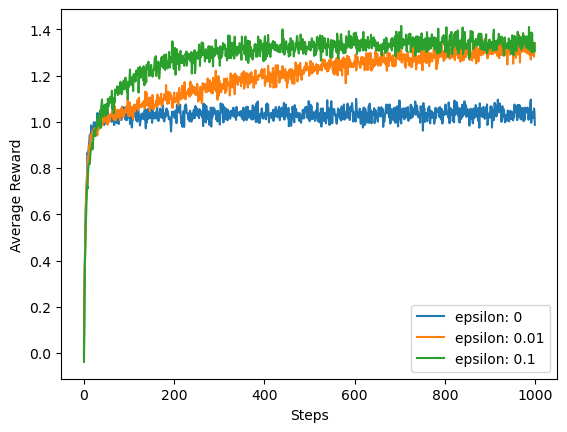

In [115]:
for epsilon in [0, 0.01, 0.1]:
    total_reward_each_step_timeline = play_test_bed(epsilon)
    total_reward_each_step_timeline = np.array(total_reward_each_step_timeline)
    average_reward_each_step_timeline = total_reward_each_step_timeline / NUM_BANDIT_PROBLEMS

    plt.plot(average_reward_each_step_timeline, label=str("epsilon: " + str(epsilon)))

plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.show()